In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py
from scipy.io import wavfile
from glob import glob
import sys
sys.path.append("../models/")
import gcc_phat

config = {
    #"continue_training_from_checkpoint" : "./models/new_type_dataset_medium_divine-shadow-51_190.pth",
    "dropout" : 0.1,
    "batch_size" : 30, 
    "max_shift" : 500, # ~10 meters
    "guess_grid_size" : 100,
    "dataset" : "new_type_dataset_medium.hdf5",
    "cnn_output_size_at_factor_1" : 576,
    "factor" : 10,
    "loss_fn" : "cross_entropy",
    "epochs" : 1000,
    "sample_length" : 10000,
    "lr" : 3e-5,
    "n_batch_before_print" : 3,
    "max_freq" : 2500,
    "rir_len" : 1600,
    "rooms_per_batch" : 30,
    "mics_per_batch" : 15,
    "warmup_steps_per_epoch" : 5,
    "warmup_epochs" : 2,
}


In [2]:
sample_len = 10000
max_shift = 500
guess_grid_size = 100
fs = 16000

dataset = ("../data/datasets/paired_fft_music_0014_evaluation.hdf5")
#dataset = ("../data/datasets/impulse_response_easy.hdf5")

model = gcc_phat.gcc_phat_model(sample_len, max_shift,guess_grid_size)

(6780, 4, 2500)
inlier ratio : 0.54


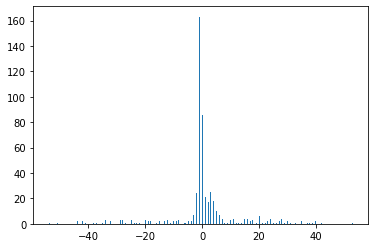

In [6]:


def y_to_class_gt(y, guess_grid_size, max_shift) :
        y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

        bin_width = max_shift*2/guess_grid_size
        y = (y/bin_width).round() + guess_grid_size // 2 
        y[y == guess_grid_size] = guess_grid_size - 1
        return y.long()

def format_simulated_data(X,y):
    """
    transform a tensor of impulse responses in different rooms into pairwise TimeEstimation-problems. Note (X and y should be on GPU)

    """
    #pull a random sound
    sound_paths = glob("../data/reference_data/reference_sounds/*.wav")
    sound_path = sound_paths[np.random.randint(len(sound_paths))]
    fs,signal = wavfile.read(sound_path)
    start = np.random.randint(0,len(signal) - config["sample_length"] - config["rir_len"]-1, X.shape[0])
    # simulate longer sound and then cut to the relevant piece
    signals = np.zeros((X.shape[0], config["sample_length"] + config["rir_len"]-1))
    for i in range(X.shape[0]):
        signals[i,:] = signal[start[i]:start[i]  + config["sample_length"] + config["rir_len"]-1]
    #signals = torch.tensor(signals).to(torch.float32).to(device).unsqueeze(1)
    signals = torch.tensor(signals).to(torch.float32).unsqueeze(1)
    q = torch.fft.irfft(torch.fft.rfft(signals)*torch.fft.rfft(X,signals.shape[2]))[:,:,:config["sample_length"]] # compute the heard sound, and cut it to the right length
    q = torch.fft.rfft(q)[:,:,:config["max_freq"]] # cut frequencies which are too high
    q = q.unsqueeze(2)
    q = torch.concatenate([torch.concatenate([q,q.roll(i+1, 1)], dim=2) for i in range(config["mics_per_batch"] // 2)],dim=1) # organize sounds pairwise
    q = q.view(X.shape[0]*(config["mics_per_batch"]*(config["mics_per_batch"] - 1 ))//2, 2,-1) # reshape so that each example is a row
    X = torch.concatenate([q.real,q.imag],dim=1)
    y = torch.concatenate([y - y.roll(i+1,1) for i in range(config["mics_per_batch"]//2)],dim=1).view(-1)*fs/343 # compute gt for all pairs
    y = y_to_class_gt(y, config["guess_grid_size"], config["max_shift"]).to(torch.long)
    
    return X,y

with h5py.File(dataset, 'r') as hdf5_file:
    X_all = hdf5_file["input"] 
    y_all = hdf5_file["gt"] 
    print(X_all.shape)

    first = 3000
    indx = torch.arange(first,first + 500)
    
    # X = torch.tensor(X_all[indx, :15])
    # y = torch.tensor(y_all[indx, :15])
    # X,y = format_simulated_data(X,y)

    X = torch.tensor(X_all[indx])
    y = torch.tensor(y_all[indx])
    y = y_to_class_gt(y*fs/343, config["guess_grid_size"], config["max_shift"]).to(torch.long)
    #print(y)

    pred = model(X).argmax(dim=1)
    plt.hist(pred - y,300)

    correct = ((pred - y).abs() < 2).sum()
    print(f'inlier ratio : {(correct/y.numel()).item():.2f}')
    #plt.plot(pred[1000])

In [6]:
device = "cpu"
class Block(nn.Module):
    def __init__(self,size):
        super().__init__()
        self.dropout = nn.Dropout(config["dropout"])
        self.l = nn.Linear(size,2*size)
        self.l2 = nn.Linear(2*size,size)
        self.act = nn.GELU()
        self.ln = nn.LayerNorm(size)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            
    def forward(self, x):
        return x + self.l2(self.act(self.l(self.ln(self.dropout(x)))))

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.thinker = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["factor"]*config["cnn_output_size_at_factor_1"],1000),
            nn.GELU(),
            #Block(1000),
            #Block(1000),
            nn.Linear(1000,config["guess_grid_size"])
        )
        
        self.apply(self._init_weights)
        
        self.cnn = nn.Sequential(
            nn.Conv1d(4,48*config["factor"], 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*config["factor"],48*config["factor"], 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*config["factor"],48*config["factor"], 30,stride=5),
            nn.GELU(),
            nn.Flatten(),
        )
        
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.00002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.00002)
        
                
    def forward(self, x):
        x = self.cnn(x)
        x = self.thinker(x)
        return x
    
model = Classifier().to(device)
model = torch.load("../models/new_type_dataset_medium_sage-shadow-58_100.pth",map_location=torch.device('cpu'))

In [24]:
# datasets_folder = "../data/datasets/"
# dataset = "impulse_response_hard_evaluation.hdf5"


# with h5py.File(datasets_folder + dataset, 'a') as h5_file:

#     X = h5_file["input"]
#     X.attrs.create("dataset_type", "impulse_response")
#     X.attrs.create("reflection_coeff", 0.3)

#     X.attrs.create("scatter_coeff", 0.15)
#     X.attrs.create("sample_length", 10000)    
#     X.attrs.create("fs", 16000)
#     X.attrs.create("speed_of_sound", 343)





# datasets_folder = "../data/datasets/"
# dataset = "paired_fft_music_0014_evaluation.hdf5"


# with h5py.File(datasets_folder + dataset, 'a') as h5_file:

#     X = h5_file["input"]
#     X.attrs.create("dataset_type", "paired_fft")
    
#     X.attrs.create("sample_length", 10000)    
#     X.attrs.create("fs", 16000)

In [25]:
# with h5py.File(datasets_folder + dataset, 'r') as h5_file:
#     X = h5_file["input"]
#     print(X.attrs.keys())

<KeysViewHDF5 ['dataset_type', 'fs', 'sample_length']>
